In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import umap.plot

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
from statannotations.Annotator import Annotator
import warnings

from pathlib import Path
import os

# Define directories for model and benchmark results
root_dir_model = Path.cwd().parents[0] / "FinalModelResults"
root_dir_bm = Path.cwd().parents[0] / "Benchmarks"

# Dataset control flags
merge_datasets = False
single_dataset = False
only_validation_compounds = False
test_plates_only = True

# Define dataset names and data stratifications
datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['test'] 

/opt/miniconda3/envs/FeatureAggregation/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
merge_datasets = False
single_dataset = False
only_validation_compounds = False
test_plates_only = False

datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['training', 'validation', 'test']
bigDF = []
for key in datasets:
    df = pd.read_csv(os.path.join(root_dir_model, f'mAP/{key}/FinalModelResults_replicating_{key}.csv'))
    # Remove BM columns and append to bottom of DF
    BMmapT = pd.DataFrame(df.loc[:, ['plate', 'Training mAP BM']]).rename(columns={'Training mAP BM': 'Training mAP model'})
    BMmapV = pd.DataFrame(df.loc[:, ['plate', 'Validation mAP BM']]).rename(columns={'Validation mAP BM': 'Training mAP model'})
    MLPmapV = pd.DataFrame(df.loc[:, ['plate', 'Validation mAP model']]).rename(columns={'Validation mAP model': 'Training mAP model'})
    df.drop(['Training mAP BM', 'Validation mAP BM', 'Validation mAP model'] , axis=1, inplace=True)
    df = pd.concat([df, BMmapT, MLPmapV, BMmapV])
    # Add dataset columns
    if merge_datasets:
        if key == 'Stain5':
            df['dataset'] = [key]*len(df)
        else:
            df['dataset'] = ['Stain2-4']*len(df)
    else:
        df['dataset'] = [key]*len(df)
    # Add method columns
    df['method'] = ['CytoSummaryNet: training compounds']*(len(df)//4) + ['average profiling: training compounds']*(len(df)//4) + ['CytoSummaryNet: validation compounds']*(len(df)//4) + ['average profiling: validation compounds']*(len(df)//4)
    # Add platelabels
    platelabels = pd.read_csv(os.path.join(root_dir_bm, f'platelabels{key}.csv'))
    df = df.merge(platelabels, on='plate')
    bigDF.append(df)
bigDF = pd.concat(bigDF)

if only_validation_compounds:
    bigDF = bigDF[bigDF.method.str.contains('validation')]
if merge_datasets:
    stratY = 2
    datasets = ['Stain2-4', 'Stain5']
else:
    if not single_dataset:
        stratY = 4
    else:
        stratY = 1

In [3]:
def add_newline_after_colon(s):
    return s.replace(':', ':\n') if isinstance(s, str) else s

bigDF['method'] = bigDF['method'].map(add_newline_after_colon)

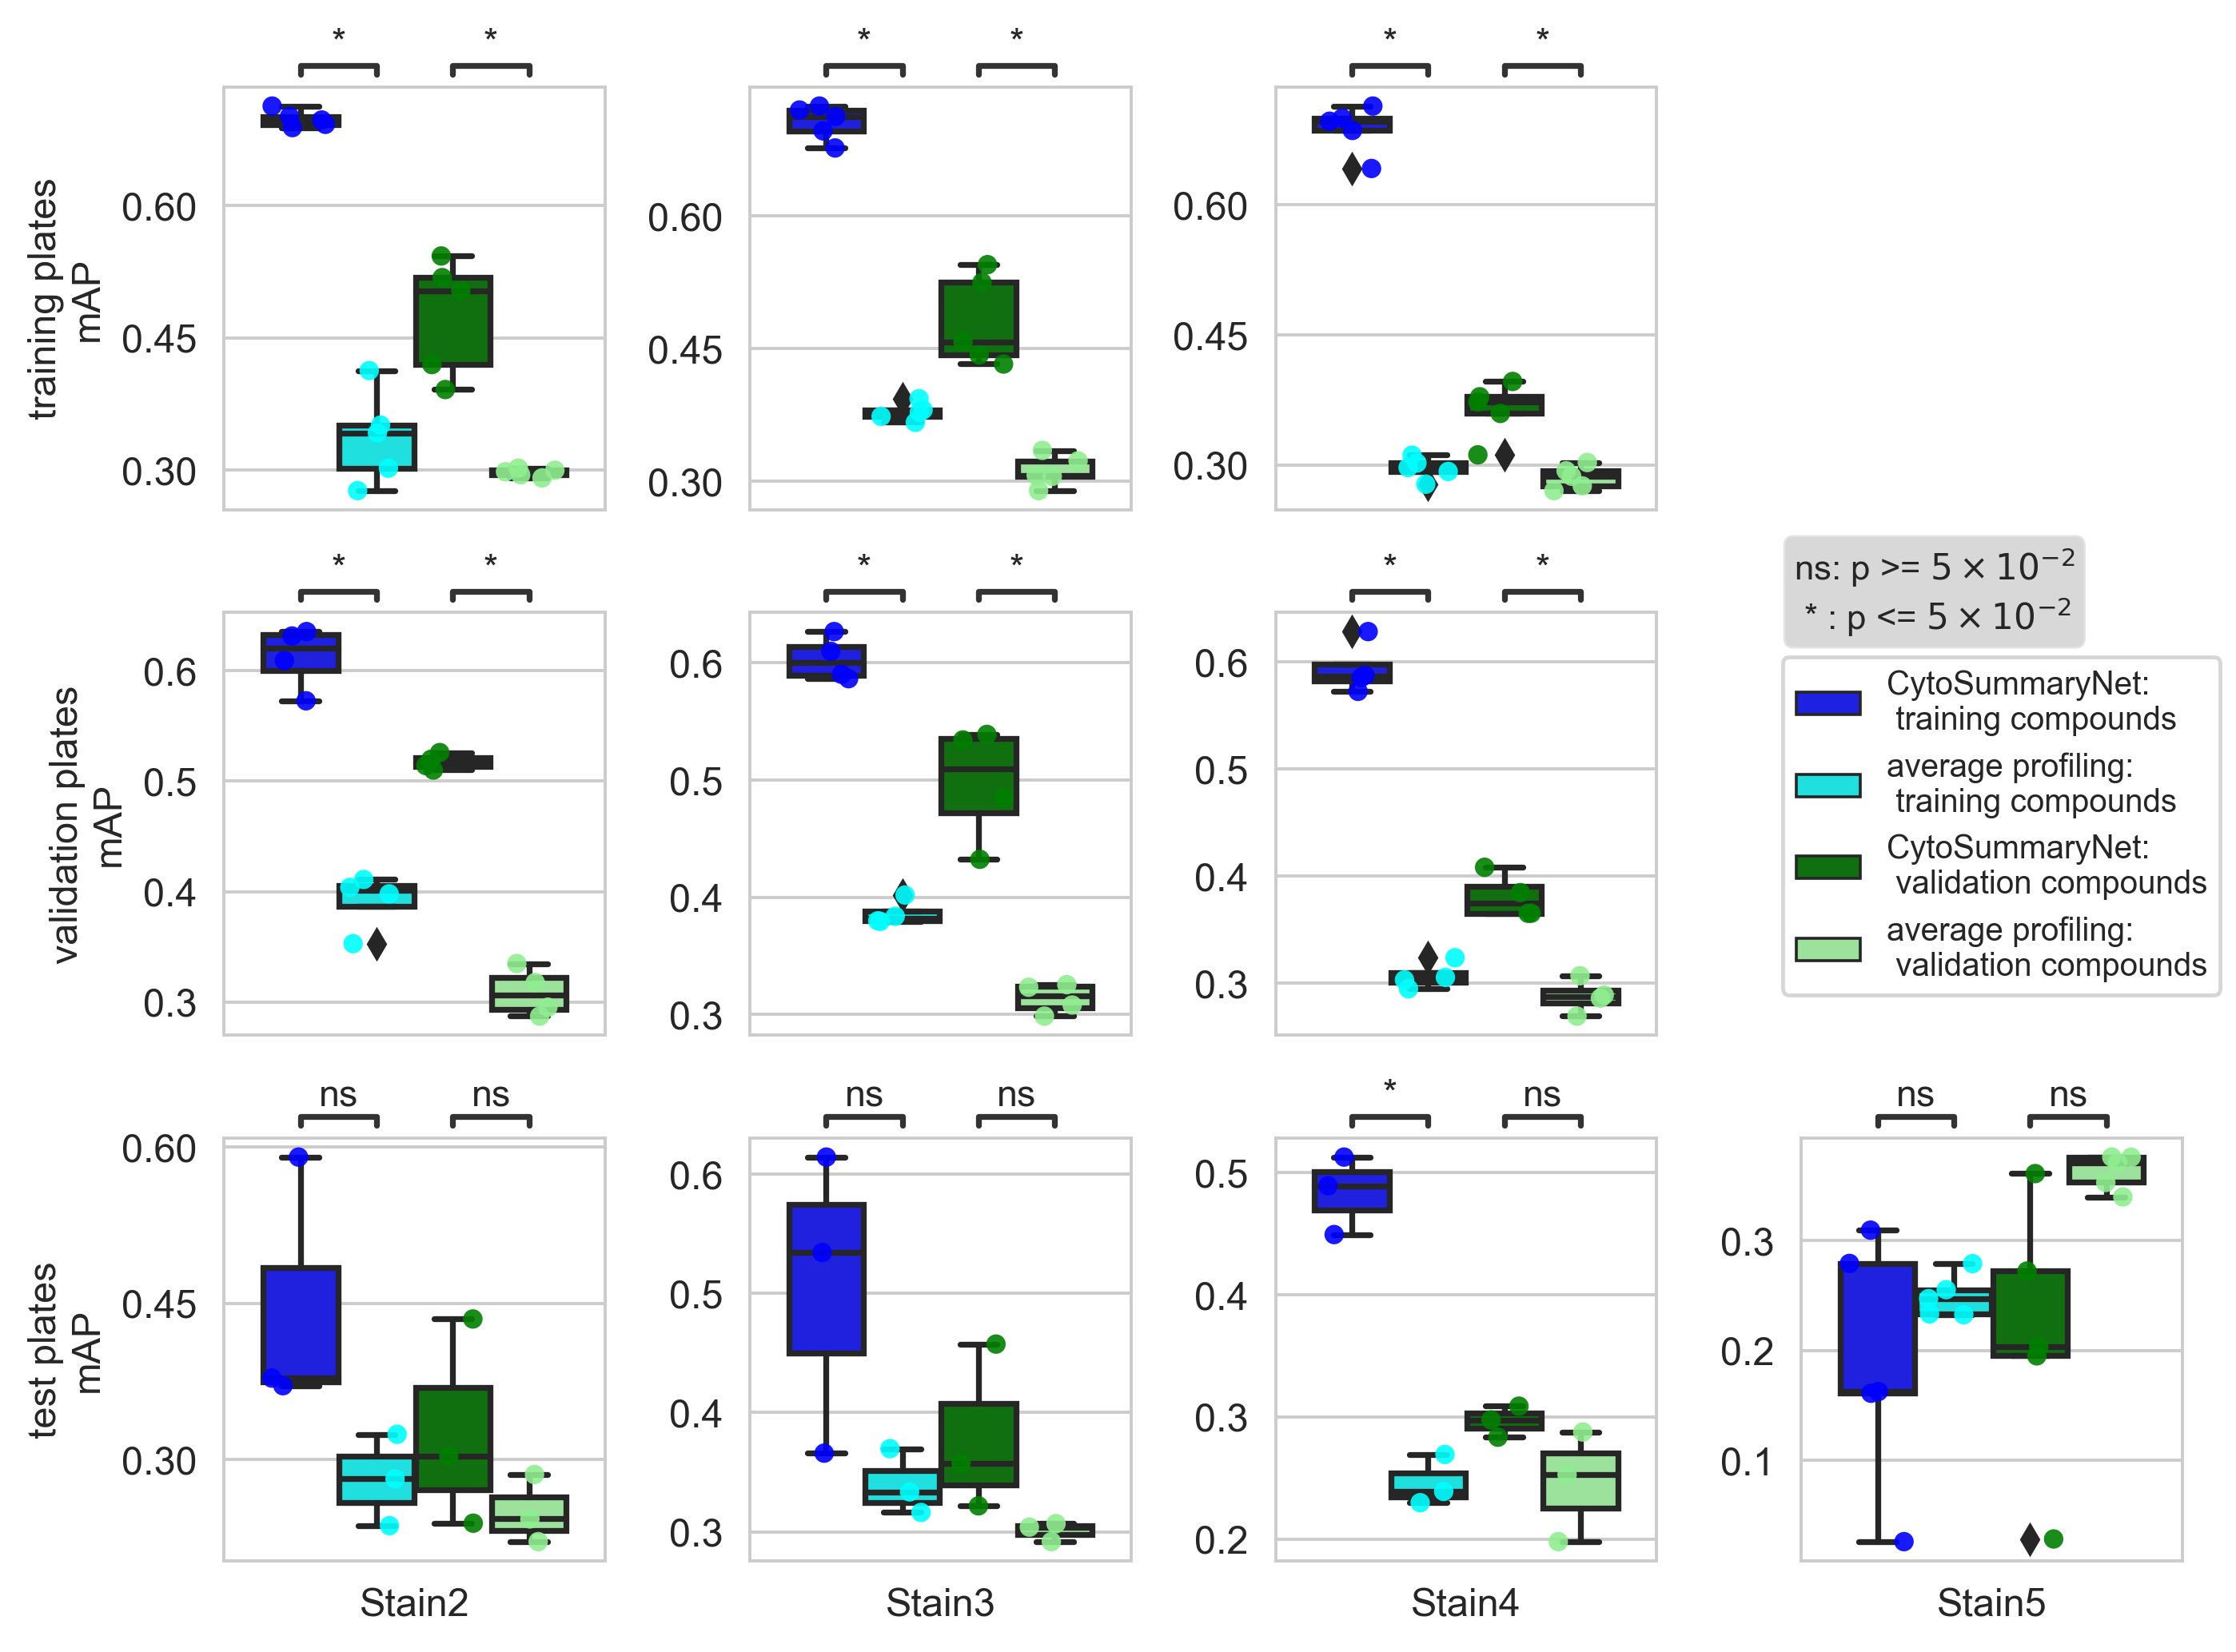

In [4]:
sns.set_style("whitegrid")

x = "dataset"
y = "Training mAP model"
hue = "method"
display_method = 'star' # star full simple

my_pal = {"CytoSummaryNet:\n validation compounds":"green", "average profiling:\n validation compounds": 'lightgreen'}
if not only_validation_compounds:
    my_pal['CytoSummaryNet:\n training compounds'] = "b"
    my_pal['average profiling:\n training compounds'] = "cyan"
    
if single_dataset:
    fig, ax = plt.subplots(1, 3, dpi=350, figsize=(8, 3))
elif test_plates_only:
    fig, ax = plt.subplots(1, stratY, dpi=350, figsize=(8, 3))
else:
    fig, ax = plt.subplots(3, stratY, dpi=350, figsize=(8, 6))
labels=None
# First loop over different datasets 
for dataset_idx in range(stratY):
    cdataset = datasets[dataset_idx]
    subDF = bigDF.loc[bigDF['dataset'] == cdataset]
    # Then over different stratifications 
    for strat_idx in range(3):
        if not single_dataset and not test_plates_only:
            if dataset_idx==stratY-1 and strat_idx<2:
                continue
        if test_plates_only and strat_idx > 0:
            continue
        subsubDF = subDF.loc[subDF['platelabel'] == stratifications[strat_idx]]
        #print(np.mean(np.array(subsubDF['mAP CytoSummaryNet'][subsubDF.method == 'CytoSummaryNet']-np.array(subsubDF['mAP CytoSummaryNet'][subsubDF.method == 'baseline'])))/np.mean(subsubDF['mAP CytoSummaryNet'][subsubDF.method == 'baseline']))
        # print(subsubDF)
        
        with sns.plotting_context("notebook", font_scale = 0.8):
            if single_dataset:
                current_ax = ax[strat_idx]
            elif test_plates_only:
                current_ax = ax[dataset_idx]
            else:
                current_ax = ax[strat_idx, dataset_idx]
            subax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=current_ax, palette=my_pal)
            

            if labels is None:
                handles, labels = subax.get_legend_handles_labels()
            sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=current_ax, palette=my_pal, alpha=0.9, dodge=True, jitter=0.3)
            if not only_validation_compounds:
                box_pairs=[((cdataset, 'CytoSummaryNet:\n training compounds'), (cdataset, 'average profiling:\n training compounds')), 
                       ((cdataset, 'CytoSummaryNet:\n validation compounds'), (cdataset, 'average profiling:\n validation compounds'))]
            else:
                 box_pairs=[((cdataset, 'CytoSummaryNet:\n validation compounds'), (cdataset, 'average profiling:\n validation compounds'))]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                annotator = Annotator(subax, pairs=box_pairs, data=subsubDF, x=x, y=y, hue=hue)
                annotator.configure(test='t-test_welch', text_format=display_method, 
                                    loc='outside', test_short_name='t-test welch', verbose=False)
                annotator.apply_and_annotate()

            # remove all the labels and ticks 
            if strat_idx != 2:
                subax.set(xticklabels=[])
            subax.set(xlabel=None)
            subax.tick_params(bottom=False)
            
            if dataset_idx != 0:
                subax.set(ylabel=None)
            else:
                if strat_idx==0 and test_plates_only:
                    pass
                elif strat_idx==0:
                    subax.set(ylabel='training plates\nmAP')
                elif strat_idx==1:
                    subax.set(ylabel='validation plates\nmAP')
                else:
                    subax.set(ylabel='test plates\nmAP')
            subax.legend([],[], frameon=False)
            subax.yaxis.set_major_locator(plt.MaxNLocator(4))

fig.subplots_adjust(hspace=0.2, wspace=0.4)
if not merge_datasets:
    if not single_dataset and not test_plates_only:
        fig.delaxes(ax[0][3])
        fig.delaxes(ax[1][3])
    else:
        pass
else:
    fig.delaxes(ax[0][1])
    fig.delaxes(ax[1][1])

fig.legend(handles, labels, loc='center right', fontsize=8.3)

textstring = r'ns: p >= $5\times10^{-2}$'+'\n'+r' * : p <= $5\times10^{-2}$'
#+'\n**: $10^{-3}$ < p <= $10^{-2}$\n***: $10^{-4}$ < p <= $10^{-3}$\n****: p <= $10^{-4}$
props = dict(boxstyle='round', facecolor='grey', alpha=0.3)
if test_plates_only:
    fig.text(-1.10, 1.85, textstring,
             fontsize=9, transform=subax.transAxes,
            verticalalignment='top', bbox=props)
elif single_dataset:
    fig.text(-0.53, 1.4, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)
else:
    fig.text(-0.02, 2.4, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)


plt.tight_layout()
    
if not merge_datasets:
    plt.savefig(os.path.join("Figures", 'FigureS1A_ReplicatemAP.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join("Figures", 'FigureS1A_ReplicatemAP_merged.png'), bbox_inches='tight')
